In [83]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random

In [84]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

In [85]:
def findFiles(path): return glob.glob(path) #Takes regex and returns all the paths that follow the regex

In [86]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicodeToAscii("O'Néàl"))

O'Neal


In [87]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


In [88]:
for filename in findFiles('dinos.txt'):
    lines = readLines(filename)

In [121]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size = 256,layers = 2, output_size = 59, drop_prob = 0.5):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.layers = layers
        self.lstm = nn.LSTM(input_size, hidden_size,layers, 
                            dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hc):
#         print(input.shape, hc[0].shape, hc[1].shape)
        x , (h,c) = self.lstm(input, hc)
        x = self.dropout(x)
        x = x.view(x.size()[0]*x.size()[1], self.hidden_size)
        x = self.fc(x)
        output = self.softmax(x)
        return output, (h,c)

    def initHidden(self, n_seqs):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x n_seqs x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        return (weight.new(self.layers, n_seqs, self.hidden_size).zero_(),
                weight.new(self.layers, n_seqs, self.hidden_size).zero_())

In [122]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    line = randomChoice(lines)
    return line

In [123]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(1, len(line), n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[0][li][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [124]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    line = randomTrainingPair()
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return input_line_tensor, target_line_tensor

In [125]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(input_line_tensor, target_line_tensor):
#    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden(1)

    rnn.zero_grad()

    loss = 0

    output, hidden = rnn(input_line_tensor, hidden)
    l = criterion(output, target_line_tensor)
    loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [126]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
rnn = RNN(n_letters, 128,2,n_letters)
print(rnn)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

RNN(
  (lstm): LSTM(59, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=59, bias=True)
  (softmax): LogSoftmax()
)
2m 32s (5000 5%) 3.9103
5m 7s (10000 10%) 3.6634
7m 52s (15000 15%) 3.1716
10m 38s (20000 20%) 3.1979
13m 22s (25000 25%) 2.8389


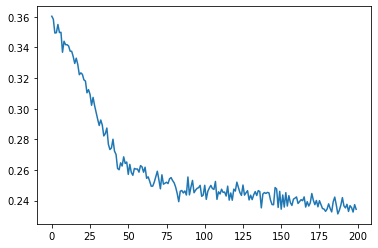

In [52]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [68]:
max_length = 20

# Sample from a category and starting letter
def sample(start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        input = inputTensor(start_letter)
        hidden = rnn.initHidden(1)

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(input, hidden)
            topv, topi = output.topk(1)
            print(output)
            print(topv, topi)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(start_letter))

samples()

tensor([[-2.3331, -4.3527, -3.6021, -3.9165, -3.1244, -4.8411, -3.7698, -3.5238,
         -3.0175, -4.7690, -4.3177, -3.3973, -3.9259, -3.0907, -2.6720, -3.6705,
         -4.9492, -2.9956, -3.3165, -3.3394, -3.2776, -4.3580, -4.8246, -4.5160,
         -3.9347, -4.7205, -4.9697, -4.9229, -4.9599, -4.8702, -4.9438, -4.9392,
         -4.9479, -4.9436, -5.0075, -4.8970, -4.9054, -4.9668, -4.9482, -4.9511,
         -5.0068, -4.9353, -4.9682, -4.9077, -4.9307, -4.9023, -4.9559, -4.9009,
         -4.9936, -4.8887, -4.9496, -4.8813, -4.9433, -4.9227, -5.0290, -4.8715,
         -4.9033, -4.9923, -3.9906]])
tensor([[-2.3331]]) tensor([[0]])
tensor([[-1.9907, -4.7272, -3.5819, -3.9339, -2.9043, -5.6572, -3.7709, -3.5236,
         -2.7812, -5.4100, -4.7063, -3.3059, -3.9834, -2.8286, -2.3287, -3.6075,
         -5.6822, -2.7046, -2.9825, -3.1477, -3.0129, -4.7248, -5.4472, -4.8902,
         -4.0431, -5.3960, -5.7929, -5.7090, -5.7360, -5.6733, -5.7416, -5.8259,
         -5.6375, -5.6893, -5.8028, -

         -7.6402, -7.7901, -3.3058]])
tensor([[-1.8526]]) tensor([[0]])
tensor([[-1.8165, -6.3769, -3.9732, -4.3937, -3.1372, -7.9652, -4.2064, -3.7321,
         -3.0719, -7.5754, -6.0421, -3.7012, -4.5858, -2.8151, -2.1193, -3.8340,
         -8.1130, -2.3175, -2.1267, -3.0637, -2.2678, -6.3103, -7.6421, -6.3226,
         -4.7126, -7.7096, -8.3894, -8.3608, -8.2405, -8.2168, -8.2562, -8.5345,
         -8.1341, -8.2368, -8.4974, -8.3592, -8.2790, -8.1696, -8.3312, -8.2049,
         -8.2713, -8.0177, -8.3379, -8.0650, -8.3717, -8.2081, -8.2629, -7.9823,
         -8.2685, -8.2203, -8.3592, -8.4710, -8.3176, -8.4096, -8.3561, -8.0502,
         -8.2629, -8.5463, -3.0750]])
tensor([[-1.8165]]) tensor([[0]])
tensor([[-1.9740, -6.6060, -4.0949, -4.4812, -3.4021, -8.4692, -4.4070, -3.8984,
         -3.1824, -8.0314, -6.3812, -3.7823, -4.9522, -2.8415, -2.2538, -3.9498,
         -8.6708, -2.2337, -2.0663, -3.1421, -2.0075, -6.5571, -8.0194, -6.6708,
         -4.7749, -8.1421, -8.9182, -8.8569, -

In [63]:
samples()

Aaaaaaasu
Baaaaaaasuu
Caaaaaasusu
